# Unsupervised Anomaly Detection on fastMRI

### *Run these cells only when in Google Colab*

In [9]:
# # Clone the repository
# !git clone https://github.com/compai-lab/mad_seminar_s23.git
# # Move all content to the current directory
# !mv ./mad_seminar_s23/* ./
# # Remove the empty directory
# !rm -rf mad_seminar_s23/

In [10]:
# # Download the data
# !wget <link you got from your supervisor>
# # Extract the data
# !unzip -q ./data.zip

In [11]:
# # Install additional packages
# !pip install pytorch_lightning --quiet
# !pip install lpips
# !pip install click
# !pip install cudatoolkit
# # !pip install faiss-cpu
# !pip install faiss-gpu
# !pip install matplotlib
# !pip install pillow
# !pip install pretrainedmodels
# !pip install torch
# !pip install scikit-image
# !pip install scikit-learn
# !pip install scipy
# !pip install torchvision
# !pip install tqdm
# !pip install timm

## Imports

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/camp1/PNI_Medical_Anomaly/

In [13]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml
import contextlib
import logging
import os
import numpy as np
import torch
import model.patchcore.backbones
import model.patchcore.common
import model.patchcore.metrics
import model.patchcore.patchcore
import model.patchcore.sampler
import model.patchcore.utils

from data_loader import TrainDataModule, get_all_test_dataloaders, get_test_dataloader
from model.patchcore.run_patchcore import dataset, run, patch_core, sampler
from model.patchcore.patchcore import PatchCore
from data_loader import TrainDataModule, get_all_test_dataloaders

# autoreload imported modules
%load_ext autoreload
%autoreload 2

## Load the config

In [14]:
with open('./configs/autoencoder_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

Global seed set to 42


42

## Load and visualize the data

(128, 128)
Using 711 IXI images and 130 fastMRI images for training. Using 15 images for validation.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape: torch.Size([1, 3, 128, 128])
Batch min: -2.1179039478302
Batch max: 2.640000104904175
1


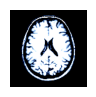

In [15]:
train_data_module = TrainDataModule(
    split_dir=config['split_dir'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])

# Plot some images
batch = next(iter(train_data_module.train_dataloader()))

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

img_num = min(5, batch.shape[0])
print(img_num)

fig, ax = plt.subplots(1, img_num, figsize=(15, img_num))
for i in range(img_num):
    ax[i].imshow(batch[i].squeeze().permute(1,2,0)) if img_num>1 else batch[i].permute(1,2,0)
    ax[i].axis('off') if img_num>1 else ax.axis('off')
# plt.show()
plt.imshow(batch[i].permute(1,2,0))
plt.show()

## Prepare Parameters

In [16]:
# we run the patchcore model

methods ={}
methods["get_dataloaders"] = {"training": train_data_module,
            "validation": train_data_module,
            "testing": test_dataloaders,
            "names": [
        'absent_septum',
        'artefacts',
        'craniatomy',
        'dural',
        'ea_mass',
        'edema',
        'encephalomalacia',
        'enlarged_ventricles',
        'intraventricular',
        'lesions',
        'mass',
        'posttreatment',
        'resection',
        'sinus',
        'wml',
        'other'
    ]}

n1, f1 = sampler('approx_greedy_coreset', 0.1 )
methods[n1] =f1
# we also pick greedy_coreset because that is what PNI paper mentions
# 0.1 is the default value according to documentation
n2, f2 =patch_core(["wideresnet101"], ['layer2', 'layer3'], 1024, 1024, "mean", "mean", 5, 3, "max", 0.0, [], True, 8)
methods[n2] = f2
# rest of values are just default


results_path = r"D:\D_Coding\Coding\PNI_Medical_Anomaly\results"
# make sure gpus is correctly used
gpu = [0]
seed = config["seed"]
log_group = "group"
log_project = "project"
save_segmentation_images = True
save_patchcore_model = True

## Run training

In [17]:
LOGGER = logging.getLogger(__name__)

_DATASETS = {"mri_images": ["PNI_Medical_Anomaly.data_loader", "TrainDataset"], }


run_save_path = model.patchcore.utils.create_storage_folder(
    results_path, log_project, log_group, mode="iterate"
)

dataloaders = methods["get_dataloaders"]

device = model.patchcore.utils.set_torch_device(gpu)
# Device context here is specifically set and used later
# because there was GPU memory-bleeding which I could only fix with
# context managers.
device_context = (
    torch.cuda.device("cuda:{}".format(device.index))
    if "cuda" in device.type.lower()
    else contextlib.suppress()
)

result_collect = []

model.patchcore.utils.fix_seeds(seed, device)

dataset_name = dataloaders["training"].name
print("sanity check")
print("name: " + dataset_name)

with device_context:
    torch.cuda.empty_cache()
    imagesize = dataloaders["training"].input_size
    sampler = methods["get_sampler"](
        device,
    )
    PatchCore_list = methods["get_patchcore"](imagesize, sampler, device)
    if len(PatchCore_list) > 1:
        LOGGER.info(
            "Utilizing PatchCore Ensemble (N={}).".format(len(PatchCore_list))
        )
    for i, PatchCore in enumerate(PatchCore_list):
        torch.cuda.empty_cache()
        if PatchCore.backbone.seed is not None:
            model.patchcore.utils.fix_seeds(PatchCore.backbone.seed, device)
        LOGGER.info(
            "Training models ({}/{})".format(i + 1, len(PatchCore_list))
        )
        torch.cuda.empty_cache()
        PatchCore.fit(dataloaders["training"].train_dataloader())

sanity check
name: training mri images


C:\Users\asnra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asnra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet101_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet101_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to C:\Users\asnra/.cache\torch\hub\checkpoints\wide_resnet101_2-32ee1156.pth
100%|

KeyboardInterrupt: 

## Refinement Network Training

In [ ]:
from model.refinement_model import Refinement
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

from tqdm import tqdm
from data_loader import TrainDataModule
from model.cutpaste import CutPasteNormal,CutPasteScar, CutPaste3Way, CutPasteUnion, cut_paste_collate_fn
from model.refinement_model import Refinement
from model.eval import eval_model

after_cutpaste_transform = transforms.Compose([])
after_cutpaste_transform.transforms.append(transforms.ToTensor())
after_cutpaste_transform.transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225]))

cutpaste_type = CutPasteNormal()

test_epochs = 10

train_transform = transforms.Compose([])
#train_transform.transforms.append(transforms.RandomResizedCrop(size, scale=(min_scale,1)))
train_transform.transforms.append(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))
# train_transform.transforms.append(transforms.GaussianBlur(int(size/10), sigma=(0.1,2.0)))
train_transform.transforms.append(transforms.Resize(config['target_size']))
train_transform.transforms.append(cutpaste_type(transform = after_cutpaste_transform))
# train_transform.transforms.append(transforms.ToTensor())

num_classes = 2

model = Refinement(config)

model.to(torch.device('cuda'))

def get_data_inf():
    while True:
        for out in enumerate(train_data_module.train_dataloader()):
            yield out
            
dataloader_inf =  get_data_inf()
optimizer = model.configure_optimizers()
loss_fn = lambda logits, y: model.loss_fn(logits, y)

for step in tqdm(range(config['num_epochs'])):
    epoch = int(step / 1)
    
    batch_embeds = []
    batch_idx, data = next(dataloader_inf)
    xs = [x.to(device) for x in data]
    
    

    # zero the parameter gradients
    optimizer.zero_grad()

    xc = PatchCore.predict(xs)
    
    logits = model(xs, xc)
    
    # calculate label
    y = torch.arange(len(xs), device=device)
    y = y.repeat_interleave(xs[0].size(0))
    loss = loss_fn(logits, y)
    
    loss.backward()
    optimizer.step()
    
    if test_epochs > 0 and epoch % test_epochs == 0:
        # run auc calculation
        #TODO: create dataset only once.
        #TODO: train predictor here or in the model class itself. Should not be in the eval part
        #TODO: we might not want to use the training datat because of droupout etc. but it should give a indecation of the model performance???
        # batch_embeds = torch.cat(batch_embeds)
        # print(batch_embeds.shape)
        model.eval()
        roc_auc= eval_model("refinement", "idk", device=device,
                            save_plots=False,
                            size=config['target_size'],
                            show_training_data=False,
                            model=model)
                            #train_embed=batch_embeds)
        model.train()


## Evaluation

In [ ]:
# Reconstructions from the validation set
with device_context:
    torch.cuda.empty_cache()
    aggregator = {"pathologies": [], "scores": [], "segmentations": []}
    for i, PatchCore in enumerate(PatchCore_list):
        torch.cuda.empty_cache()
        LOGGER.info(
            "Embedding test data with models ({}/{})".format(
                i + 1, len(PatchCore_list)
            )
        )
        for name in methods["get_dataloaders"]["names"]:
            scores, segmentations, labels_gt, masks_gt = PatchCore.predict(
                dataloaders["testing"][name]
            )
            aggregator["pathologies"].append(name)
            aggregator["scores"].append(scores)
            aggregator["segmentations"].append(segmentations)

In [ ]:
from evaluate import Evaluator

evaluator = Evaluator(PatchCore, torch.device('cuda'), test_dataloaders)

metrics, fig_metrics, fig_example = evaluator.evaluate()

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [on]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/squeeze.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
*********************** DATASET: absent_septum ********************


/content/drive/MyDrive/camp1/PNI_Medical_Anomaly/evaluate.py:165: RuntimeWarning:

Mean of empty slice



L1 mean: nan +/- nan
LPIPS mean: nan +/- nan
SSIM mean: nan +/- nan
TP mean: 1.0 +/- 0.0
TP: 1 of 1 detected
FP mean: 41.0 +/- 0.0
FP: 41 missed
Precision mean: 0.023809523809523808 +/- 0.0
Recall mean: 1.0 +/- 0.0
F1 mean: 0.04651162745267713 +/- 0.0
*********************** DATASET: artefacts ********************
L1 mean: nan +/- nan
LPIPS mean: nan +/- nan
SSIM mean: nan +/- nan
TP mean: 1.0 +/- 0.0
TP: 16 of 16 detected
FP mean: 97.8125 +/- 124.07972172659802
FP: 1565 missed
Precision mean: 0.05534476172762422 +/- 0.08327069648503939
Recall mean: 1.0 +/- 0.0
F1 mean: 0.09484113899696453 +/- 0.12773225979092076
*********************** DATASET: craniatomy ********************
L1 mean: nan +/- nan
LPIPS mean: nan +/- nan
SSIM mean: nan +/- nan
TP mean: 1.0 +/- 0.0
TP: 15 of 15 detected
FP mean: 90.66666666666667 +/- 134.4027116128573
FP: 1360 missed
Precision mean: 0.061296073397302475 +/- 0.0813116509379416
Recall mean: 1.0 +/- 0.0
F1 mean: 0.10606310174418722 +/- 0.12384579418629363


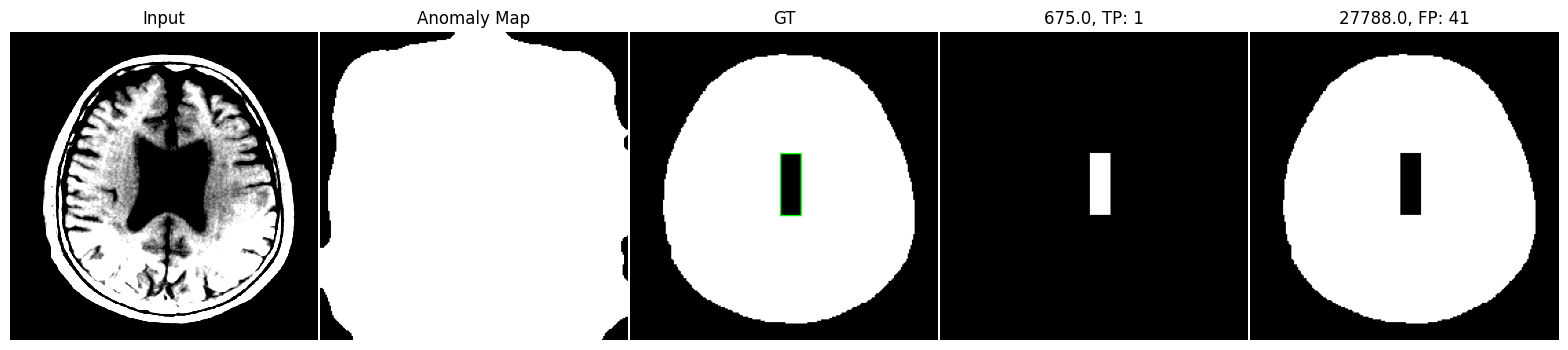

In [ ]:
fig_example

In [ ]:
fig_metrics['F1']